# 랭그래프로 간단한 챗봇 만들기

## 필요 라이브러리 설치

In [1]:
%pip install langgraph

Note: you may need to restart the kernel to use updated packages.


## GPT 모델 설정

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

# 모델 초기화
model = ChatOpenAI(model="gpt-4o-mini")
model.invoke('안녕하세요!')

/Users/euni/miniforge3/envs/llm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b547601dbd', 'id': 'chatcmpl-Ci1T7f9p6i72Bds6NCbXMXQRS0IuH', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--d23821cc-3f6f-4090-b8f3-03443c9986e7-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## 상태 정의
- `Annotated[T, func]`: 타입 T에 메타데이터나 동작을 추가할 때 사용
- `add_messages`: LangGraph가 제공하는 Reducer로 기존 메시지 리스트를 덮어쓰지않고 새로운 메시지를 리스트 뒤에 추가
  - `Reducer`? 함수형 프로그래밍에서 온 개념으로 기존 값과 새 값을 어떻게 합칠 것인가를 정의하는 함수

In [10]:
from typing import Annotated # annotated는 타입 힌트를 사용할 때 사용하는 함수
from typing_extensions import TypedDict # TypedDict는 딕셔너리 타입을 정의할 때 사용하는 함수

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    """
    State 클래스는 TypedDict를 상속받습니다.

    속성:
        messages (Annotated[list[str], add_messages]): 메시지들은 "list" 타입을 가집니다.
       'add_messages' 함수는 이 상태 키가 어떻게 업데이트되어야 하는지를 정의합니다.
        (이 경우, 메시지를 덮어쓰는 대신 리스트에 추가합니다)
    """
    messages: Annotated[list[str], add_messages]



## 그래프 정의
- StateGraph를 생성할 때 상태의 스키마로 State 전달
- 그래프가 처리할 데이터의 형태를 정의

In [ ]:
graph_builder = StateGraph(State)

## 챗봇 노드 함수 정의

In [11]:
def generate(state: State):
    """
    주어진 상태를 기반으로 챗봇의 응답 메시지를 생성합니다.

    매개변수:
    state (State): 현재 대화 상태를 나타내는 객체로, 이전 메시지들이 포함되어 있습니다.
		
    반환값:
    dict: 모델이 생성한 응답 메시지를 포함하는 딕셔너리. 
          형식은 {"messages": [응답 메시지]}입니다.
    """ 
    return {"messages": [model.invoke(state["messages"])]}


graph_builder.add_node("generate", generate) # 그래프에 노드 추가

## 엣지 정의 및 컴파일

In [12]:
graph_builder.add_edge(START, "generate")
graph_builder.add_edge("generate", END)    

graph = graph_builder.compile()

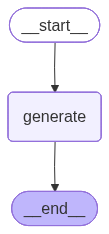

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception: 
    pass

## 그래프 실행
- 응답 메시지 : {'messages': [HumanMessage(...), AIMessage(...)]}

In [14]:
response = graph.invoke({"messages": ["안녕하세요! 저는 김정은입니다"]})

print(type(response))
response

<class 'dict'>


{'messages': [HumanMessage(content='안녕하세요! 저는 김정은입니다', additional_kwargs={}, response_metadata={}, id='d94f5769-628a-4717-a5d1-e83e52c3fc18'),
  AIMessage(content='안녕하세요, 김정은님! 무엇을 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 15, 'total_tokens': 31, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b547601dbd', 'id': 'chatcmpl-Ci1UpyDzNhiuaHwRpZjrQgVRxOuo3', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--cd732a3d-de62-4d56-8674-546781e1bf86-0', usage_metadata={'input_tokens': 15, 'output_tokens': 16, 'total_tokens': 31, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

In [15]:
response["messages"].append("제 이름을 아시나요?")
graph.invoke(response)

{'messages': [HumanMessage(content='안녕하세요! 저는 김정은입니다', additional_kwargs={}, response_metadata={}, id='d94f5769-628a-4717-a5d1-e83e52c3fc18'),
  AIMessage(content='안녕하세요, 김정은님! 무엇을 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 15, 'total_tokens': 31, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b547601dbd', 'id': 'chatcmpl-Ci1UpyDzNhiuaHwRpZjrQgVRxOuo3', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--cd732a3d-de62-4d56-8674-546781e1bf86-0', usage_metadata={'input_tokens': 15, 'output_tokens': 16, 'total_tokens': 31, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),

## 스트리밍 출력

In [16]:
inputs = {"messages": [("human", "한국과 일본의 관계에 대해 자세히 알려줘")]}
for chunk, _ in graph.stream(inputs, stream_mode="messages"):
    print(chunk.content, end="")

한국과 일본의 관계는 역사적으로 복잡하고 다층적인 측면을 가지고 있습니다. 이들 두 국가는 지리적으로 가까운 이웃국가이며, 문화적, 경제적, 정치적으로 많은 연관을 가지고 있지만, 역사적 갈등과 긴장도 존재합니다.

### 역사적 배경

1. **근대 이전**: 한국과 일본은 오랜 역사 동안 교류를 해왔습니다. 하지만 서로에 대한 인식이나 관계는 변천을 겪어왔습니다.

2. **일제강점기 (1910-1945)**: 일본이 한국을 강제로 합병하고 식민 통치를 한 시기입니다. 이 시기 동안 많은 한국인이 일본의 식민지 정책과 차별에 저항하였고, 이러한 역사적 경험은 오늘날까지도 양국 관계에 큰 영향을 미치고 있습니다. 특히 강제징용, 위안부 문제 등은 한국 국민들에게 깊은 상처를 남겨왔습니다.

3. **전후**: 일본이 제2차 세계대전에서 패망한 이후, 한국은 1945년에 해방되었지만 곧이어 1948년 남북으로 분단되었습니다. 이후에도 한국과 일본 간의 관계는 냉전 시대의 정치적 상황에 따라 영향을 받았습니다.

### 현대의 관계

1. **경제 협력**: 1965년 한일 정상화 조약이 체결되면서 두 나라 간의 경제적 협력이 본격적으로 시작되었습니다. 이후 일본은 한국의 산업 발전에 큰 역할을 했고, 한국 또한 일본에게 중요한 무역 파트너가 되었습니다.

2. **정치적 갈등**: 역사 문제, 영토 분쟁 (예: 독도 문제), 그리고 일본의 군사 확대 등 여러 가지 정치적 이슈로 인해 양국 간의 긴장이 종종 발생하고 있습니다. 특히 역사 교과서 문제나 일본의 우경화 조치 등은 한국 내에서 강한 반발을 불러일으키곤 했습니다.

3. **문화 교류**: 2000년대 들어 한류가 일본에서 인기를 끌면서 문화적으로도 활발한 교류가 이루어지고 있습니다. K-pop, 드라마, 영화 등 다양한 문화 콘텐츠가 일본에서 큰 호응을 얻고 있습니다.

### 최근 동향

한국과 일본의 관계는 국제 정세에 따라 변화하고 있습니다. 특히 미국의 외교 정책과도 관련이 있으며, 북한의 핵